In [6]:
import re
from bert_embedding import BertEmbedding

In [70]:
import pandas as pd

In [3]:
text = """On MR images of the sub-and supratentorial structures of the brain, supplemented by intravenous contrast (Gadovist 10 ml) obtained the following data:
• in the brain substance numerous formations of specific genesis in both hemispheres of the brain were revealed:
o - at least 7 in the left hemisphere - from 2mm to 4.5mm in diameter;
o - at least 4 in the right cerebral hemisphere from 2mm to 8x7mm in the supratentorial regions of the frontal-parietal region, 14x17mm in the basal regions of the temporal lobe;
o - in the left hemisphere of the cerebellum two formations 9x7.5mm and 9.2x8.3mm"""

In [11]:
text

'On MR images of the sub-and supratentorial structures of the brain, supplemented by intravenous contrast (Gadovist 10 ml) obtained the following data:\n• in the brain substance numerous formations of specific genesis in both hemispheres of the brain were revealed:\no - at least 7 in the left hemisphere - from 2mm to 4.5mm in diameter;\no - at least 4 in the right cerebral hemisphere from 2mm to 8x7mm in the supratentorial regions of the frontal-parietal region, 14x17mm in the basal regions of the temporal lobe;\no - in the left hemisphere of the cerebellum two formations 9x7.5mm and 9.2x8.3mm'

In [9]:
pattern = re.compile(r'[a-zA-Z0-9]+')

In [12]:
wordlist = pattern.findall(text)

In [13]:
be = BertEmbedding()

Vocab file is not found. Downloading.


In [15]:
embs = be(wordlist)

In [92]:
train_df = pd.read_csv('/Users/artem/pyprojects/brain-tumor/data/TRAIN_SET/ozerki_annotated_not_segmented/brain-text1.csv', names=['name', 'annot', 'label'])

In [419]:
train_df['label'].to_csv('labels.txt', sep='\n', header=False, index=False)

In [95]:
X = train_df['annot']

In [68]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel

batch_size = 32
X_train, y_train = samples_from_file('train.csv') # Put your own data loading function here
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
X_train = [tokenizer.tokenize('[CLS] ' + sent + ' [SEP]') for sent in X_train] # Appending [CLS] and [SEP] tokens - this probably can be done in a cleaner way
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model = bert_model.cuda()

X_train_tokens = [tokenizer.convert_tokens_to_ids(sent) for sent in X_train]
results = torch.zeros((len(X_test_tokens), bert_model.config.hidden_size)).long()
with torch.no_grad():
    for stidx in range(0, len(X_test_tokens), batch_size):
        X = X_test_tokens[stidx:stidx + batch_size]
        X = torch.LongTensor(X).cuda()
        _, pooled_output = bert_model(X)
        results[stidx:stidx + batch_size,:] = pooled_output.cpu()

In [87]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 487585.31B/s]


In [100]:
bert_model = BertModel.from_pretrained('bert-base-uncased')

100%|██████████| 407873900/407873900 [04:18<00:00, 1579449.69B/s]


In [147]:
class InputExample(object):

    def __init__(self, unique_id, text_a, text_b=None):
        self.unique_id = unique_id
        self.text_a = text_a
        self.text_b = text_b
    
    def __repr__(self):
        return self.text_a

In [248]:
def read_sequence(input_sentences):
    examples = []
    unique_id = 0
    for sentence in input_sentences:
        examples.append(InputExample(unique_id=unique_id, text_a=sentence))
        unique_id += 1
    return examples

examples = read_sequence(X)

In [127]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, unique_id, tokens, input_ids, input_mask, input_type_ids):
        self.unique_id = unique_id
        self.tokens = tokens
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.input_type_ids = input_type_ids

In [247]:
def convert_examples_to_features(examples, seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""

    features = []
    for (ex_index, example) in enumerate(examples):
        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > seq_length - 2:
                tokens_a = tokens_a[0:(seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0     0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = []
        input_type_ids = []
        tokens.append("[CLS]")
        input_type_ids.append(0)
        for token in tokens_a:
            tokens.append(token)
            input_type_ids.append(0)
        tokens.append("[SEP]")
        input_type_ids.append(0)
        
        if tokens_b:
            for token in tokens_b:
                tokens.append(token)
                input_type_ids.append(1)
            tokens.append("[SEP]")
            input_type_ids.append(1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        while len(input_ids) < seq_length:
            input_ids.append(0)
            input_mask.append(0)
            input_type_ids.append(0)

        assert len(input_ids) == seq_length, f'{input_ids, len(input_ids)}'
        assert len(input_mask) == seq_length
        assert len(input_type_ids) == seq_length

        features.append(
            InputFeatures(
                unique_id=example.unique_id,
                tokens=tokens,
                input_ids=input_ids,
                input_mask=input_mask,
                input_type_ids=input_type_ids))
    return features

def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

In [249]:
MAX_SEQ_LENGTH = 256
features = convert_examples_to_features(examples, seq_length=MAX_SEQ_LENGTH, tokenizer=tokenizer)

In [214]:
def get_features(input_text, dim=768):
    layer_indexes = LAYERS
  
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  
    examples = read_sequence(input_text)
  
    features = convert_examples_to_features(
        examples=examples, seq_length=MAX_SEQ_LENGTH, tokenizer=tokenizer)
  
    unique_id_to_feature = {}
    for feature in features:
        unique_id_to_feature[feature.unique_id] = feature
  
    model_fn = model_fn_builder(
        bert_config=bert_config,
        init_checkpoint=INIT_CHECKPOINT,
        layer_indexes=layer_indexes,
        use_tpu=True,
        use_one_hot_embeddings=True)
  
    input_fn = input_fn_builder(
        features=features, seq_length=MAX_SEQ_LENGTH)
  
    # Get features
    for result in estimator.predict(input_fn, yield_single_examples=True):
        unique_id = int(result["unique_id"])
        feature = unique_id_to_feature[unique_id]
        output = collections.OrderedDict()
        for (i, token) in enumerate(feature.tokens):
            layers = []
            for (j, layer_index) in enumerate(layer_indexes):
                layer_output = result["layer_output_%d" % j]
                layer_output_flat = np.array([x for x in layer_output[i:(i + 1)].flat])
                layers.append(layer_output_flat)
            output[token] = sum(layers)[:dim]
    
    return output

In [265]:
bert_model(torch.LongTensor([31, 51, 99]))

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [263]:
batch_size = 2
results = torch.zeros((256, bert_model.config.hidden_size)).long()
with torch.no_grad():
    for stidx in range(0, 256, batch_size):
        X = X_test_tokens[stidx:stidx + batch_size]
        X = torch.LongTensor(X).cuda()
        _, pooled_output = bert_model(X)
        results[stidx:stidx + batch_size,:] = pooled_output.cpu()

bert_model(torch.LongTensor(features[0].input_ids))

NameError: name 'X_test_tokens' is not defined

In [320]:
def read_examples(input_file):
    """Read a list of `InputExample`s from an input file."""
    examples = []
    unique_id = 0
    with open(input_file, "r", encoding='utf-8') as reader:
        while True:
            line = reader.readline()
            if not line:
                break
            line = line.strip()
            text_a = None
            text_b = None
            m = re.match(r"^(.*) \|\|\| (.*)$", line)
            if m is None:
                text_a = line
            else:
                text_a = m.group(1)
                text_b = m.group(2)
            examples.append(
                InputExample(unique_id=unique_id, text_a=text_a, text_b=text_b))
            unique_id += 1
    return examples

In [270]:
ex = read_examples('../../brain-tumor/data/TRAIN_SET/ozerki_annotated_not_segmented/brain-text.txt')

In [274]:
with open('../../brain-tumor/data/TRAIN_SET/ozerki_annotated_not_segmented/annotations2.txt') as f:
    text = f.read()

In [279]:
patients = text.split('\n\n')

In [291]:
for i, patient in enumerate(patients):
    patients[i] = patient.replace('\n', ' ')

In [293]:
patients[0]

'On MR images of the sub-and supratentorial structures of the brain, supplemented by intravenous contrast (Gadovist 10 ml) obtained the following data: - in the substance of the brain, numerous formations of specific genesis in both hemispheres of the brain were revealed: - at least 7 in the left big hemisphere - from 2mm to 4.5mm diameter - at least 4 in the right big hemisphere from 2mm to 8x7mm in the supratentorial parts of the frontal-parietal region, 14x17mm in the basal parts of the temporal lobe \xa0- in the left hemisphere of the cerebellum, two formations 9x7.5mm and 9.2x8.3mm \xa0Peritumorous edema is noted around the largest foci, the structure of the larger formations is heterogeneous due to the central cystic areas (decay). The total number of lesions is not less than 13. - at the level of the basal nuclei, the seven oval centers, there are enlarged perivascular spaces along the penetrating vessels. The median structures are not displaced. The ventricular system is not ex

In [311]:
with open('annotations3.txt', 'w') as f:
    for item in patients:
        f.write('%s\n' % item)

In [312]:
with open('annotations3.txt') as f:
    text = f.read()
text.split('\n').__len__()

10

In [316]:
patients.__len__()

9

In [322]:
ex = read_examples('annotations3.txt')

In [327]:
ex[8].unique_id

8

In [328]:
import torch

In [329]:
!python -V

Python 3.7.3


In [332]:
import json

In [334]:
!ls

2019-05-25-armavox-initial-experiments.html
2019-05-25-armavox-initial-experiments.ipynb
2019-05-25-armavox-initial-experiments.py
annotations3.txt


In [347]:
inp_ids = torch.LongTensor(features[0].input_ids)
inp_mask = torch.LongTensor(features[0].input_mask)

In [355]:
from torch.utils.data import TensorDataset, SequentialSampler, DistributedSampler, DataLoader

In [44]:
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)

eval_data = TensorDataset(all_input_ids, all_input_mask, all_example_index)
if -1 == -1:
    eval_sampler = SequentialSampler(eval_data)
else:
    eval_sampler = DistributedSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=1)

NameError: name 'features' is not defined

In [556]:
with torch.no_grad():
    emb_dataset = []
    for inp_id, inp_mask, ex_index in eval_dataloader:
        layers, _ = bert_model(inp_id, token_type_ids=None, attention_mask=inp_mask)
        stack_last_4_layers = torch.stack(layers[-4:])
        embedding = torch.sum(stack_last_4_layers, dim=0)
        emb_dataset.append(embedding)
    dataset = TensorDataset(torch.cat(emb_dataset, dim=0))

In [557]:
dataset[0]

(tensor([[-1.0425, -2.4814, -1.8390,  ..., -0.5512, -0.4835,  1.5930],
         [ 1.0903,  1.1847,  1.3407,  ..., -3.5326,  2.3582,  0.8856],
         [ 0.9706, -2.7299,  2.1926,  ..., -2.4728,  1.5163,  1.4311],
         ...,
         [ 1.5891, -2.0211,  0.3038,  ..., -0.6105, -0.1159,  1.4353],
         [-3.7915, -0.1638,  1.0181,  ...,  0.8057, -2.2369,  0.0546],
         [-2.3669, -1.2402,  1.7978,  ...,  0.3479, -1.4650, -1.1721]]),)

In [552]:
TensorDataset(torch.cat(emb_dataset, dim=0))[0]

(tensor([[-1.0425, -2.4814, -1.8390,  ..., -0.5512, -0.4835,  1.5930],
         [ 1.0903,  1.1847,  1.3407,  ..., -3.5326,  2.3582,  0.8856],
         [ 0.9706, -2.7299,  2.1926,  ..., -2.4728,  1.5163,  1.4311],
         ...,
         [ 1.5891, -2.0211,  0.3038,  ..., -0.6105, -0.1159,  1.4353],
         [-3.7915, -0.1638,  1.0181,  ...,  0.8057, -2.2369,  0.0546],
         [-2.3669, -1.2402,  1.7978,  ...,  0.3479, -1.4650, -1.1721]]),)

In [374]:
_.shape

torch.Size([3, 768])

In [382]:
eval_data[0]

(tensor([  101,  2006,  2720,  4871,  1997,  1996,  4942,  1011,  1998, 10514,
         18098,  3686, 13663, 14482,  5090,  1997,  1996,  4167,  1010, 20585,
          2011, 26721,  8159,  3560,  5688,  1006, 11721,  3527, 11365,  2102,
          2184, 19875,  1007,  4663,  1996,  2206,  2951,  1024,  1999,  1996,
          4167,  9415,  3365, 13197,  1997,  3563, 11046,  1999,  2119, 14130,
          2015,  1997,  1996,  4167,  2020,  3936,  1024,  2012,  2560,  1021,
          1999,  1996,  2187, 14130,  1011,  2013,  1016,  7382,  2000,  1018,
          1012,  1019,  7382,  1999,  6705,  1025,  2012,  2560,  1018,  1999,
          1996,  2157, 18439, 14130,  2013,  1016,  7382,  2000,  1022,  2595,
          2581,  7382,  1999,  1996, 10514, 18098,  3686, 13663, 14482,  4655,
          1997,  1996, 19124,  1011, 11968,  2666,  9080,  2555,  1010,  2403,
          2595, 16576,  7382,  1999,  1996, 15191,  4655,  1997,  1996, 15850,
         21833,  1025,  1999,  1996,  2187, 14130,  

In [390]:
list(iter(eval_dataloader))[-1]

[tensor([[  101,  2006,  1037,  2186,  1997,  2363, 27011,  3419,  8649,  6444,
           2015,  1997,  1996,  4167,  2007, 26721,  8159,  3560, 22133,  1006,
          11721,  3527, 11365,  2102,  1021,  1012,  1019, 19875,  1007,  1999,
           2093,  9738,  1010,  4942,  1011,  1998,  4469, 15338, 11069,  2140,
           5090,  2020,  5107,  3550,  1012,  4102,  2007,  1996,  2720,  1011,
           2817,  1997,  5757,  1013,  2538,  1013,  2760,  1024,  1996,  3130,
           5071,  4649,  3258,  1999,  1996,  2157, 19124, 21833,  2003,  2025,
           5107,  3550,  1011,  1996,  4358,  4649,  3258,  1999,  1996,  2187,
          19124, 21833,  3445,  1999,  2946,  2000,  1018,  1012,  1023,  2595,
           2509,  1012,  1016,  7382,  1006,  3130,  1016,  2595,  2487,  7382,
           1007,  1011, 10047, 14526,  2575,  1037,  2415,  2596,  1999,  1996,
           2187,  1051, 14693, 23270,  2389, 21833, 10047,  2683,  2581,  2000,
           1017,  1012,  1021,  1035,  1

In [410]:
torch.tensor(
            [f.input_ids for f in features], dtype=torch.long
        ).unsqueeze(1).shape

torch.Size([9, 1, 256])

In [398]:
bert_model(inp_ind, token_type_ids=None, attention_mask=inp_mask)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [404]:
list(iter(eval_dataloader))[-1][0].shape

torch.Size([1, 256])

In [405]:
list(eval_data[-1])[0].shape

torch.Size([256])

In [420]:
def read_examples(input_file):
    """Read a list of `InputExample`s from an input file."""
    examples = []
    unique_id = 0
    with open(input_file, "r", encoding='utf-8') as reader:
        while True:
            line = reader.readline()
            if not line:
                break
            line = line.strip()
            text_a = None
            text_b = None
            m = re.match(r"^(.*) \|\|\| (.*)$", line)
            if m is None:
                text_a = line
            else:
                text_a = m.group(1)
                text_b = m.group(2)
            examples.append(
                InputExample(unique_id=unique_id, text_a=text_a, text_b=text_b))
            unique_id += 1
    return examples

In [423]:
read_examples('annotations_eng.txt')[-1]

On a series of obtained MRI tomograms of the brain with iv contrasting (Gadovist 7.5 ml), sub- and supratentorial structures were visualized in three planes. Compared with the MR-study of 06/21/2018: - the previously assumed lesion in the right frontal lobe is not visualized - estimated focus in the left frontal lobe - increased in size to 4.9x3.2mm (previously 2x1mm) - Im116 - A focus appeared in the left occipital lobe Im97 to 3.7x3.5mm - focus in the right hemisphere of the cerebellum with dimensions up to 6.5x4.5mm (previously 4.5x4.0 mm) Im38 . - mts foci in the left temporal region up to 11x5.8mm (previously 9.6x7.3mm) Im 60 and right insular 3.2x2.4mm (=) Im 83. The formation of a lesion in the cortical regions of the right temporal lobe cannot be excluded - up to 3 mm Im 58  In the subcortical regions of the frontal and parietal lobes, isolated foci of a dystrophic nature of 1-2 mm in diameter are noted. The median structures are not displaced. The lateral ventricles of the bra

In [428]:
with open('labels.txt') as f:
    labels = []
    for line in f:
        labels.append(float(line.strip('\n')))

In [429]:
labels

[13.0, 9.0, 50.0, 5.0, 25.0, 16.0, 8.0, 10.0, 6.0]

In [431]:
eval_data[:4]

(tensor([[ 101, 2006, 2720,  ...,    0,    0,    0],
         [ 101, 2006, 2720,  ..., 2039, 2000,  102],
         [ 101, 2006, 1996,  ...,    0,    0,    0],
         [ 101, 1996, 2206,  ...,    0,    0,    0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([0, 1, 2, 3]))

In [433]:
from torch.utils.data import Dataset

In [439]:
def read_labels(input_file):
    with open(input_file) as f:
        labels = []
        for line in f:
            labels.append(float(line.strip('\n')))
        return labels

In [45]:
class BertFeaturesDataset(Dataset):
    """
    Parameters
    ----------
    input_file : str
        Path to input file with strings
    bert_model : str
        Bert pre-trained model selected in the list: bert-base-uncased,
        bert-large-uncased, bert-base-cased, bert-base-multilingual,
        bert-base-chinese.
    """
    def __init__(self, input_file, labels_file, bert_model, max_seq_length=256):

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        n_gpu = torch.cuda.device_count()

        tokenizer = BertTokenizer.from_pretrained(
            bert_model, do_lower_case=True
        )
        examples = read_examples(input_file)
        features = convert_examples_to_features(
            examples=examples, seq_length=max_seq_length, tokenizer=tokenizer
        )

        self.model = BertModel.from_pretrained(bert_model)
        self.model.to(device)

        if n_gpu > 1:
            self.model = torch.nn.DataParallel(self.model)

        self.all_input_ids = torch.tensor(
            [f.input_ids for f in features], dtype=torch.long
        )
        self.all_input_mask = torch.tensor(
            [f.input_mask for f in features], dtype=torch.long
        )
        self.all_example_index = torch.arange(
            self.all_input_ids.size(0), dtype=torch.long
        )
        self.dataset = TensorDataset(self.all_input_ids,
                                     self.all_input_mask,
                                     self.all_example_index)
        self.labels = read_labels(labels_file)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx], self.labels[idx]

In [46]:
bert = BertFeaturesDataset('annotations_eng.txt', 'labels.txt', 'bert-base-uncased')

In [47]:
bert_loader = DataLoader(bert, batch_size=1)

In [51]:
(inp_id, inp_mask, ex_index), _  = next(iter(bert_loader))

In [53]:
model = BertModel.from_pretrained('bert-base-uncased')

In [55]:
layers, pool = model(inp_id, token_type_ids=None,attention_mask=inp_mask)

In [73]:
t = TensorDataset(torch.stack(layers[-4:]))[0]

In [74]:
type(t)

tuple

In [43]:
bert[0][0]

(tensor([[-0.1111, -3.9795,  0.5539,  ..., -0.5093, -0.0370,  2.2630],
         [ 0.1307,  3.3981,  2.7187,  ..., -2.5683,  2.2881,  2.3324],
         [-0.1444, -2.0087,  2.1238,  ..., -2.7082,  1.6944,  2.0819],
         ...,
         [-2.5823, -0.0720,  2.4898,  ..., -1.4330, -1.5861, -1.6957],
         [-0.8712, -1.5009,  0.1221,  ..., -1.8574,  1.3310, -0.0285],
         [ 0.3578,  0.4861,  0.0684,  ...,  0.2164, -0.3041, -0.3666]]),)

In [85]:
# coding=utf-8
# Copyright 2018 The Google AI Language Team Authors and The HuggingFace Inc. team.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Extract pre-computed feature vectors from a PyTorch BERT model."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import collections
import logging
import json
import re

import torch
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from torch.utils.data.distributed import DistributedSampler

from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.modeling import BertModel


class InputExample(object):

    def __init__(self, unique_id, text_a, text_b):
        self.unique_id = unique_id
        self.text_a = text_a
        self.text_b = text_b


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, unique_id, tokens, input_ids, input_mask, input_type_ids):
        self.unique_id = unique_id
        self.tokens = tokens
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.input_type_ids = input_type_ids


def convert_examples_to_features(examples, seq_length, tokenizer):
    """Loads a data file into a list of `InputFeature`s."""

    features = []
    for (ex_index, example) in enumerate(examples):
        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > seq_length - 2:
                tokens_a = tokens_a[0:(seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids:   0   0  0    0    0     0      0   0    1  1  1   1  1   1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids:   0   0   0   0  0     0   0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = []
        input_type_ids = []
        tokens.append("[CLS]")
        input_type_ids.append(0)
        for token in tokens_a:
            tokens.append(token)
            input_type_ids.append(0)
        tokens.append("[SEP]")
        input_type_ids.append(0)

        if tokens_b:
            for token in tokens_b:
                tokens.append(token)
                input_type_ids.append(1)
            tokens.append("[SEP]")
            input_type_ids.append(1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        while len(input_ids) < seq_length:
            input_ids.append(0)
            input_mask.append(0)
            input_type_ids.append(0)

        assert len(input_ids) == seq_length
        assert len(input_mask) == seq_length
        assert len(input_type_ids) == seq_length

        features.append(
            InputFeatures(
                unique_id=example.unique_id,
                tokens=tokens,
                input_ids=input_ids,
                input_mask=input_mask,
                input_type_ids=input_type_ids))
    return features


def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()


def read_examples(input_file):
    """Read a list of `InputExample`s from an input file."""
    examples = []
    unique_id = 0
    with open(input_file, "r", encoding='utf-8') as reader:
        while True:
            line = reader.readline()
            if not line:
                break
            line = line.strip()
            text_a = None
            text_b = None
            m = re.match(r"^(.*) \|\|\| (.*)$", line)
            if m is None:
                text_a = line
            else:
                text_a = m.group(1)
                text_b = m.group(2)
            examples.append(
                InputExample(unique_id=unique_id, text_a=text_a, text_b=text_b))
            unique_id += 1
    return examples


def read_labels(input_file):
    with open(input_file) as f:
        labels = []
        for line in f:
            labels.append(float(line.strip('\n')))
        return labels


class BertFeaturesDataset(Dataset):
    """
    Parameters
    ----------
    input_file : str
        Path to input file with strings
    bert_model : str
        Bert pre-trained model selected in the list: bert-base-uncased,
        bert-large-uncased, bert-base-cased, bert-base-multilingual,
        bert-base-chinese.
    """

    def __init__(self, input_file, labels_file, bert_model,
                 max_seq_length=256, batch_size=4):

        self.input_file = input_file
        self.labels_file = labels_file
        self.bert_model = bert_model
        self.max_seq_length = max_seq_length
        self.batch_size = batch_size

        self.tensor_dataset = self.init_bert_dataset(
            self.input_file, self.labels_file,
            self.bert_model, self.max_seq_length
        )
        self.dataset = self.get_bert_embeddings(self.tensor_dataset,
                                                self.bert_model,
                                                self.batch_size)

        self.labels = read_labels(self.labels_file)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = {
            'embedding': self.dataset[idx][0],
            'label': self.labels[idx]
        }
        return sample

    def init_bert_dataset(self, input_file, labels_file, bert_model,
                          max_seq_length):

        tokenizer = BertTokenizer.from_pretrained(
            bert_model, do_lower_case=True
        )
        examples = read_examples(input_file)
        features = convert_examples_to_features(
            examples=examples, seq_length=max_seq_length, tokenizer=tokenizer
        )

        self.all_input_ids = torch.tensor(
            [f.input_ids for f in features], dtype=torch.long
        )
        self.all_input_mask = torch.tensor(
            [f.input_mask for f in features], dtype=torch.long
        )
        self.all_example_index = torch.arange(
            self.all_input_ids.size(0), dtype=torch.long
        )
        return TensorDataset(self.all_input_ids,
                             self.all_input_mask,
                             self.all_example_index)

    def get_bert_embeddings(self, tensor_dataset, bert_model, batch_size):

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        n_gpu = torch.cuda.device_count()
        model = BertModel.from_pretrained(bert_model)
        model.to(device)
        if n_gpu > 1:
            model = torch.nn.DataParallel(model)

        sampler = SequentialSampler(tensor_dataset)
        dataloader = DataLoader(tensor_dataset, sampler=sampler,
                                batch_size=self.batch_size)

        embedding_dataset = []
        with torch.no_grad():
            for inp_id, inp_mask, ex_index in dataloader:
                layers, _ = model(inp_id, token_type_ids=None,
                                  attention_mask=inp_mask)
                stack_last_4_layers = torch.stack(layers[-4:])
                embedding = torch.sum(stack_last_4_layers, dim=0)
                embedding_dataset.append(embedding)

        return TensorDataset(torch.cat(embedding_dataset, dim=0))


In [86]:
bert = BertFeaturesDataset('annotations_eng.txt', 'labels.txt', 'bert-base-uncased')

In [91]:
dl = DataLoader(bert, batch_size=3)

In [92]:
for batch in dl:
    emb = batch['embedding']

In [97]:
bert[:4]['embedding'].shape

torch.Size([4, 256, 768])

In [84]:
bert[0]['embedding']

(tensor([[-0.7085, -2.8616,  0.9038,  ..., -0.9680,  0.5881,  1.7080],
         [-0.7054,  1.4616,  2.0468,  ..., -2.7652,  2.0887,  2.3874],
         [ 0.6190, -0.5387,  2.2620,  ..., -2.5470,  1.0681,  0.7075],
         ...,
         [-2.2679, -0.7138,  0.4543,  ..., -2.2436, -2.4452, -3.4292],
         [-0.6971, -0.0125,  2.4319,  ..., -2.5187,  0.9869,  0.9003],
         [ 0.4324,  0.2754,  0.1237,  ...,  0.0489, -0.1980, -0.3975]]),)

(tensor([[-0.1111, -3.9795,  0.5539,  ..., -0.5093, -0.0370,  2.2630],
         [ 0.1307,  3.3981,  2.7187,  ..., -2.5683,  2.2881,  2.3324],
         [-0.1444, -2.0087,  2.1238,  ..., -2.7082,  1.6944,  2.0819],
         ...,
         [-2.5823, -0.0720,  2.4898,  ..., -1.4330, -1.5861, -1.6957],
         [-0.8712, -1.5009,  0.1221,  ..., -1.8574,  1.3310, -0.0285],
         [ 0.3578,  0.4861,  0.0684,  ...,  0.2164, -0.3041, -0.3666]]),)

In [100]:
import pandas as pd

In [106]:

df = pd.read_csv('../../brain-tumor/data/TRAIN_SET/ozerki_annotated_not_segmented/brain-labels.csv', header=None, dtype={0:str, 1:int})

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 2 columns):
0    9 non-null object
1    9 non-null int64
dtypes: int64(1), object(1)
memory usage: 224.0+ bytes


In [116]:
df.iloc[:,0].to_list()

['G10', 'G9', 'G7', 'G6', 'G5', 'G4', 'G3', 'G2', 'G1']

In [18]:
import os
path_to_img_folder = '../../brain-tumor/data/TRAIN_SET/ozerki_annotated_not_segmented/'
patient_name = 'G10'

In [121]:
path = os.path.join(path_to_img_folder, patient_name)

In [123]:
path

'../../brain-tumor/data/TRAIN_SET/ozerki_annotated_not_segmented/G10'

In [125]:
import glob

In [22]:
def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

In [139]:
l = list(listdir_nohidden(path))

In [140]:
l

['S70']

In [179]:


def read_images(path_to_img_folder, patient_name):
    path = os.path.join(path_to_img_folder, patient_name)
    mod_list = list(listdir_nohidden(path))
    filelist = list(listdir_nohidden(os.path.join(path, mod_list[0])))
    filelist = sorted(filelist, key=lambda x: int(x[1:]))
    for file in filelist:
        yield glob.glob(os.path.join(path_to_img_folder, patient_name, mod_list[0], file))[0]
    

In [180]:
for file in read_image(path_to_img_folder, patient_name):
    print(file)

../../brain-tumor/data/TRAIN_SET/ozerki_annotated_not_segmented/G10/S70/I10
../../brain-tumor/data/TRAIN_SET/ozerki_annotated_not_segmented/G10/S70/I20
../../brain-tumor/data/TRAIN_SET/ozerki_annotated_not_segmented/G10/S70/I30
../../brain-tumor/data/TRAIN_SET/ozerki_annotated_not_segmented/G10/S70/I40
../../brain-tumor/data/TRAIN_SET/ozerki_annotated_not_segmented/G10/S70/I50
../../brain-tumor/data/TRAIN_SET/ozerki_annotated_not_segmented/G10/S70/I60
../../brain-tumor/data/TRAIN_SET/ozerki_annotated_not_segmented/G10/S70/I70
../../brain-tumor/data/TRAIN_SET/ozerki_annotated_not_segmented/G10/S70/I80
../../brain-tumor/data/TRAIN_SET/ozerki_annotated_not_segmented/G10/S70/I90
../../brain-tumor/data/TRAIN_SET/ozerki_annotated_not_segmented/G10/S70/I100
../../brain-tumor/data/TRAIN_SET/ozerki_annotated_not_segmented/G10/S70/I110
../../brain-tumor/data/TRAIN_SET/ozerki_annotated_not_segmented/G10/S70/I120
../../brain-tumor/data/TRAIN_SET/ozerki_annotated_not_segmented/G10/S70/I130
../../br

In [17]:
path_to_img_folder

NameError: name 'path_to_img_folder' is not defined

In [170]:
sorted(list(read_image(path_to_img_folder, patient_name)), key=lambda x: int(x[1:]))

['I10',
 'I20',
 'I30',
 'I40',
 'I50',
 'I60',
 'I70',
 'I80',
 'I90',
 'I100',
 'I110',
 'I120',
 'I130',
 'I140',
 'I150',
 'I160',
 'I170',
 'I180',
 'I190',
 'I200',
 'I210',
 'I220',
 'I230',
 'I240',
 'I250',
 'I260',
 'I270',
 'I280',
 'I290',
 'I300',
 'I310',
 'I320',
 'I330',
 'I340',
 'I350',
 'I360',
 'I370',
 'I380',
 'I390',
 'I400',
 'I410',
 'I420',
 'I430',
 'I440',
 'I450',
 'I460',
 'I470',
 'I480',
 'I490',
 'I500',
 'I510',
 'I520',
 'I530',
 'I540',
 'I550',
 'I560',
 'I570',
 'I580',
 'I590',
 'I600',
 'I610',
 'I620',
 'I630',
 'I640',
 'I650',
 'I660',
 'I670',
 'I680',
 'I690',
 'I700',
 'I710',
 'I720',
 'I730',
 'I740',
 'I750',
 'I760',
 'I770',
 'I780',
 'I790',
 'I800',
 'I810',
 'I820',
 'I830',
 'I840',
 'I850',
 'I860',
 'I870',
 'I880',
 'I890',
 'I900',
 'I910',
 'I920',
 'I930',
 'I940',
 'I950',
 'I960',
 'I970',
 'I980',
 'I990',
 'I1000',
 'I1010',
 'I1020',
 'I1030',
 'I1040',
 'I1050',
 'I1060',
 'I1070',
 'I1080',
 'I1090',
 'I1100',
 'I1110'

In [19]:
import pydicom
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [81]:
img = pydicom.dcmread('../../brain-tumor/data/TRAIN_SET/ozerki_annotated_not_segmented/G4/S140/I210').pixel_array


In [82]:
img.shape

(256, 232)

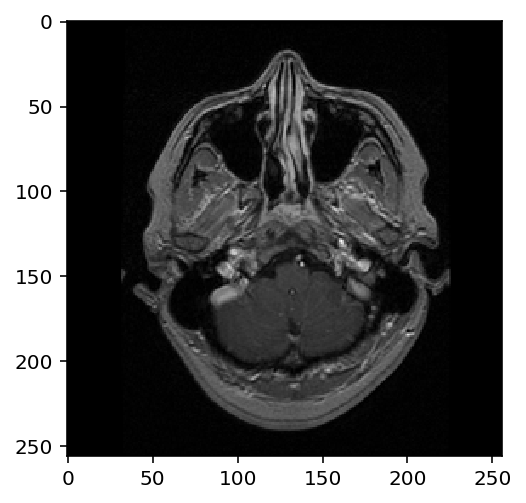

In [13]:
plt.imshow(img, cmap=cm.gray)

In [20]:
def images_path(path_to_img_folder, patient_name):
    path = os.path.join(path_to_img_folder, patient_name)
    mod_list = list(listdir_nohidden(path))  # TODO: handle several modalities
    filelist = list(listdir_nohidden(os.path.join(path, mod_list[0])))
    filelist = sorted(filelist, key=lambda x: int(x[1:]))
    for file in filelist:
        yield glob.glob(os.path.join(path_to_img_folder,
                        patient_name, mod_list[0], file))[0]


def read_image(path_to_image_file):
    return pydicom.dcmread(path_to_image_file).pixel_array


def stack_images(path_to_img_folder, patient_name):
    image = []
    for img_path in images_path(path_to_img_folder, patient_name):
        image.append(read_image(img_path))
    return np.array(image)

In [26]:
import glob
import numpy as np

In [28]:
stack_images(path_to_img_folder, patient_name)

(152, 256, 256)

In [3]:
# coding=utf-8
# Copyright 2018 The Google AI Language Team Authors and The HuggingFace Inc. team.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Extract pre-computed feature vectors from a PyTorch BERT model."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import collections
import logging
import json
import re
import os
import numpy as np
import pandas as pd
import pydicom
import glob
from PIL import Image

import torch
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from torch.utils.data.distributed import DistributedSampler

from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.modeling import BertModel


class InputExample(object):

    def __init__(self, unique_id, text_a, text_b):
        self.unique_id = unique_id
        self.text_a = text_a
        self.text_b = text_b


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, unique_id, tokens, input_ids, input_mask, input_type_ids):
        self.unique_id = unique_id
        self.tokens = tokens
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.input_type_ids = input_type_ids


def convert_examples_to_features(examples, seq_length, tokenizer):
    """Loads a data file into a list of `InputFeature`s."""

    features = []
    for (ex_index, example) in enumerate(examples):
        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > seq_length - 2:
                tokens_a = tokens_a[0:(seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids:   0   0  0    0    0     0      0   0    1  1  1   1  1   1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids:   0   0   0   0  0     0   0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = []
        input_type_ids = []
        tokens.append("[CLS]")
        input_type_ids.append(0)
        for token in tokens_a:
            tokens.append(token)
            input_type_ids.append(0)
        tokens.append("[SEP]")
        input_type_ids.append(0)

        if tokens_b:
            for token in tokens_b:
                tokens.append(token)
                input_type_ids.append(1)
            tokens.append("[SEP]")
            input_type_ids.append(1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        while len(input_ids) < seq_length:
            input_ids.append(0)
            input_mask.append(0)
            input_type_ids.append(0)

        assert len(input_ids) == seq_length
        assert len(input_mask) == seq_length
        assert len(input_type_ids) == seq_length

        features.append(
            InputFeatures(
                unique_id=example.unique_id,
                tokens=tokens,
                input_ids=input_ids,
                input_mask=input_mask,
                input_type_ids=input_type_ids))
    return features


def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()


def read_examples(input_file):
    """Read a list of `InputExample`s from an input file."""
    examples = []
    unique_id = 0
    with open(input_file, "r", encoding='utf-8') as reader:
        while True:
            line = reader.readline()
            if not line:
                break
            line = line.strip()
            text_a = None
            text_b = None
            m = re.match(r"^(.*) \|\|\| (.*)$", line)
            if m is None:
                text_a = line
            else:
                text_a = m.group(1)
                text_b = m.group(2)
            examples.append(
                InputExample(unique_id=unique_id, text_a=text_a, text_b=text_b))
            unique_id += 1
    return examples


def read_labels(input_file):
    with open(input_file) as f:
        labels = []
        for line in f:
            labels.append(float(line.strip('\n')))
        return labels


def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f


def images_path(path_to_img_folder, patient_name):
    path = os.path.join(path_to_img_folder, patient_name)
    mod_list = list(listdir_nohidden(path))  # TODO: handle several modalities
    filelist = list(listdir_nohidden(os.path.join(path, mod_list[0])))
    filelist = sorted(filelist, key=lambda x: int(x[1:]))
    for file in filelist:
        yield glob.glob(os.path.join(path_to_img_folder,
                        patient_name, mod_list[0], file))[0]


def read_image(path_to_image_file):
    p_array = np.array(pydicom.dcmread(path_to_image_file).pixel_array)
    pil_img = Image.fromarray(p_array)
    pil_img = pil_img.resize((256, 256))
    p_array = np.array(pil_img, dtype='int64')
    return p_array


# TODO: Eliminate of bones
def stack_images(path_to_img_folder, patient_name):
    image = []
    for img_path in images_path(path_to_img_folder, patient_name):
        image.append(read_image(img_path))
    return np.array(image)


class BertFeaturesDataset(Dataset):
    """
    Parameters
    ----------
    input_file : str
        Path to input file with strings
    bert_model : str
        Bert pre-trained model selected in the list: bert-base-uncased,
        bert-large-uncased, bert-base-cased, bert-base-multilingual,
        bert-base-chinese.
    """

    def __init__(self, imgs_folder, input_text_file, labels_file, bert_model,
                 max_seq_length=256, batch_size=4):

        self.imgs_folder = imgs_folder
        self.input_file = input_text_file
        self.labels_file = labels_file
        self.bert_model = bert_model
        self.max_seq_length = max_seq_length
        self.batch_size = batch_size

        self.tensor_dataset = self.init_bert_dataset(
            self.input_file, self.labels_file,
            self.bert_model, self.max_seq_length
        )
        self.dataset = self.get_bert_embeddings(self.tensor_dataset,
                                                self.bert_model,
                                                self.batch_size)
        df = pd.read_csv(self.labels_file, header=None, dtype={0: str, 1: int})
        self.labels = df.iloc[:, 1].values
        self.names = df.iloc[:, 0].to_list()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        name = self.names[idx]
        img = stack_images(self.imgs_folder, name)

        sample = {
            'image': img,
            'embedding': self.dataset[idx],
            'label': self.labels[idx],
            'name': self.names[idx]
        }
        return sample

    def init_bert_dataset(self, input_file, labels_file, bert_model,
                          max_seq_length):

        tokenizer = BertTokenizer.from_pretrained(
            bert_model, do_lower_case=True
        )
        examples = read_examples(input_file)
        features = convert_examples_to_features(
            examples=examples, seq_length=max_seq_length, tokenizer=tokenizer
        )

        self.all_input_ids = torch.tensor(
            [f.input_ids for f in features], dtype=torch.long
        )
        self.all_input_mask = torch.tensor(
            [f.input_mask for f in features], dtype=torch.long
        )
        self.all_example_index = torch.arange(
            self.all_input_ids.size(0), dtype=torch.long
        )
        return TensorDataset(self.all_input_ids,
                             self.all_input_mask,
                             self.all_example_index)

    def get_bert_embeddings(self, tensor_dataset, bert_model, batch_size):

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        n_gpu = torch.cuda.device_count()
        model = BertModel.from_pretrained(bert_model)
        model.to(device)
        if n_gpu > 1:
            model = torch.nn.DataParallel(model)

        sampler = SequentialSampler(tensor_dataset)
        dataloader = DataLoader(tensor_dataset, sampler=sampler,
                                batch_size=self.batch_size)

        embedding_dataset = []
        with torch.no_grad():
            for inp_id, inp_mask, ex_index in dataloader:
                layers, _ = model(inp_id, token_type_ids=None,
                                  attention_mask=inp_mask)
                stack_last_4_layers = torch.stack(layers[-4:])
                embedding = torch.sum(stack_last_4_layers, dim=0)
                embedding_dataset.append(embedding)

        return TensorDataset(torch.cat(embedding_dataset, dim=0))


In [4]:
path_to_img_folder = '../../brain-tumor/data/TRAIN_SET/ozerki_annotated_not_segmented/'

In [5]:
def stack_images(path_to_img_folder, patient_name):
    image = []
    for img_path in images_path(path_to_img_folder, patient_name):
        image.append(read_image(img_path))
    return np.array(image)

In [ ]:
plt.imshow(imgs[160])

In [5]:
bert = BertFeaturesDataset(path_to_img_folder, 'annotations_eng.txt', 'brain-labels.csv', 'bert-base-uncased')


In [4]:
import glob
import numpy as np
from torch.utils.data import SequentialSampler
sampler = SequentialSampler(bert)

In [5]:
dl = DataLoader(bert, sampler=sampler, batch_size=1)

In [114]:
for i, batch in enumerate(dl):
    print(i)
    print(batch['image'].shape)

0
torch.Size([1, 152, 256, 256])
1
torch.Size([1, 152, 256, 256])
2
torch.Size([1, 180, 256, 256])
3
torch.Size([1, 152, 256, 256])
4
torch.Size([1, 152, 256, 256])
5
torch.Size([1, 176, 256, 256])
6
torch.Size([1, 152, 256, 256])
7
torch.Size([1, 152, 256, 256])
8
torch.Size([1, 152, 256, 256])


In [6]:
import matplotlib.pyplot as plt
img = bert[2]['image'][160,:,:]

In [9]:
im = np.array(img, dtype='uint16')

In [ ]:
plt.imshow(bert[2]['image'][160,:,:])

In [1]:
plt.imshow(img)

NameError: name 'plt' is not defined

In [10]:
import PIL
from PIL import Image

In [11]:
im = Image.fromarray(im)

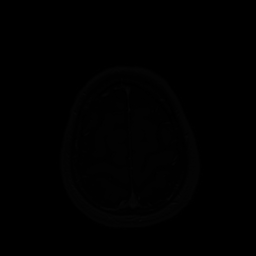

In [12]:
im

In [100]:
np.array(im.resize((256,256)), dtype='int64')

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  1,  1, ...,  1,  0,  0],
       [ 0,  1,  2, ...,  2,  2,  1],
       ...,
       [ 0, 17, 19, ...,  1,  2,  2],
       [ 0, 17, 17, ...,  3,  3,  3],
       [ 0, 12, 14, ...,  2,  1,  3]])